<a href="https://colab.research.google.com/github/DarkStarQuantumLab/Adiabatic-QML/blob/main/HFT_Qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 -m pip install -q qiskit
!python3 -m pip install -q qiskit_ibm_runtime

In [ ]:
!python3 -m pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.1 MB/s eta 0:00:00


The question: we know from direct game theoretic analysis that the quantum nash equilibrium occurs when both players only use two parameter strategies. in fact, the quantum nash equilibrium dissappears when they use 3 parameter strategies. we want to know if a reinforcement learning approach, using only limited 3 parameter data, produces the quantum nash equilibrium for appropprtiate choices of alpha( the learning rate) and epsilon.

In [ ]:
import numpy as np
import pandas as pd
from qiskit import IBMQ, BasicAer, Aer
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.extensions.unitary import UnitaryGate
from qiskit.execute_function import execute
from typing import Dict, Optional
from sympy import Matrix
from sympy.physics.quantum import TensorProduct

In [ ]:
num_players = 2

# define the payoff matrices. Assume, the 1st matrix is Alice's payoff, the secomd matrix is Bob's payoff
payoff_matrix =[[[3, 0],
                [5, 1]],
                [[3, 5],
                [0, 1]]]

In [ ]:
# calculating payoffs

def get_payoff(counts):
  """
    Calculate the reward for the players after the game ends.
  """
  payoff_bob = []
  payoff_alice = []

  for strategy, prob in counts.items():
    strategy_bob = int(strategy[1])
    strategy_alice = int(strategy[0])
    payoff_bob.append(prob * payoff_matrix[0][strategy_alice][strategy_bob])
    payoff_alice.append(prob * payoff_matrix[0][strategy_bob][strategy_alice])

  return sum(payoff_alice), sum(payoff_bob)

In [ ]:
# define the simulator
simulator = Aer.get_backend('statevector_simulator')

**QLearning 2x2**

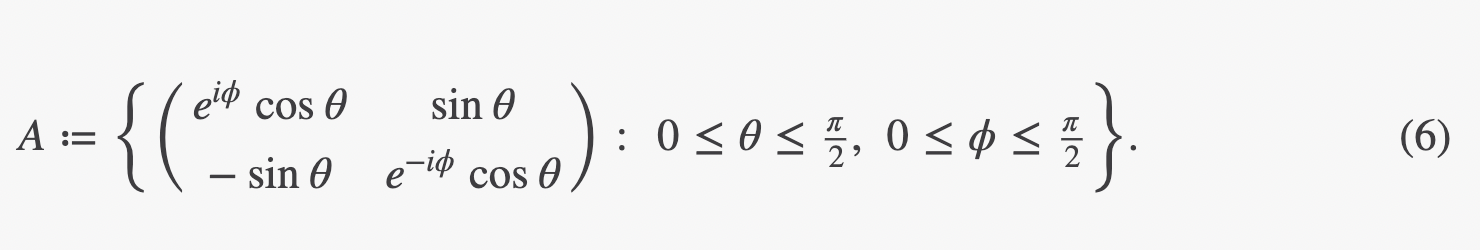

In [ ]:
def build_qcir_two_by_two_parameters(theta1, phi1, theta2, phi2):

  alice = np.array([
      [np.exp(1.0j*phi1)*np.cos(theta1), np.sin(theta1)],
      [-np.sin(theta1), np.exp(-1.0j*phi1)*np.cos(theta1)]])

  bob = np.array([
      [np.exp(1.0j*phi2)*np.cos(theta2), np.sin(theta2)],
      [-np.sin(theta2), np.exp(-1.0j*phi2)*np.cos(theta2)]])

  qc = QuantumCircuit(num_players)

  J = 1/np.sqrt(2)*np.array([[1.0, 0.0, 0.0, 1.0j],
                             [0.0, 1.0, 1.0j, 0.0],
                             [0.0, 1.0j, 1.0, 0.0],
                             [1.0j, 0.0, 0.0, 1.0]]).astype(complex)

  J_unitary = UnitaryGate(Operator(J))
  qc.append(J_unitary, [0,1])
  qc.barrier()

  unitary_alice = UnitaryGate(Operator(alice))
  unitary_bob = UnitaryGate(Operator(bob))

  qc.append(unitary_alice, [0])
  qc.append(unitary_bob, [1])
  qc.barrier()

  Jdagger_unitary = UnitaryGate(Operator(J.conj().T))
  qc.append(Jdagger_unitary, [0,1])

  return qc



In [ ]:
space_size = 4

actions_list = []

for theta1 in np.linspace(0, np.pi/2, space_size):
  for phi1 in np.linspace(0, np.pi/2, space_size):
      actions_list.append((theta1,phi1))

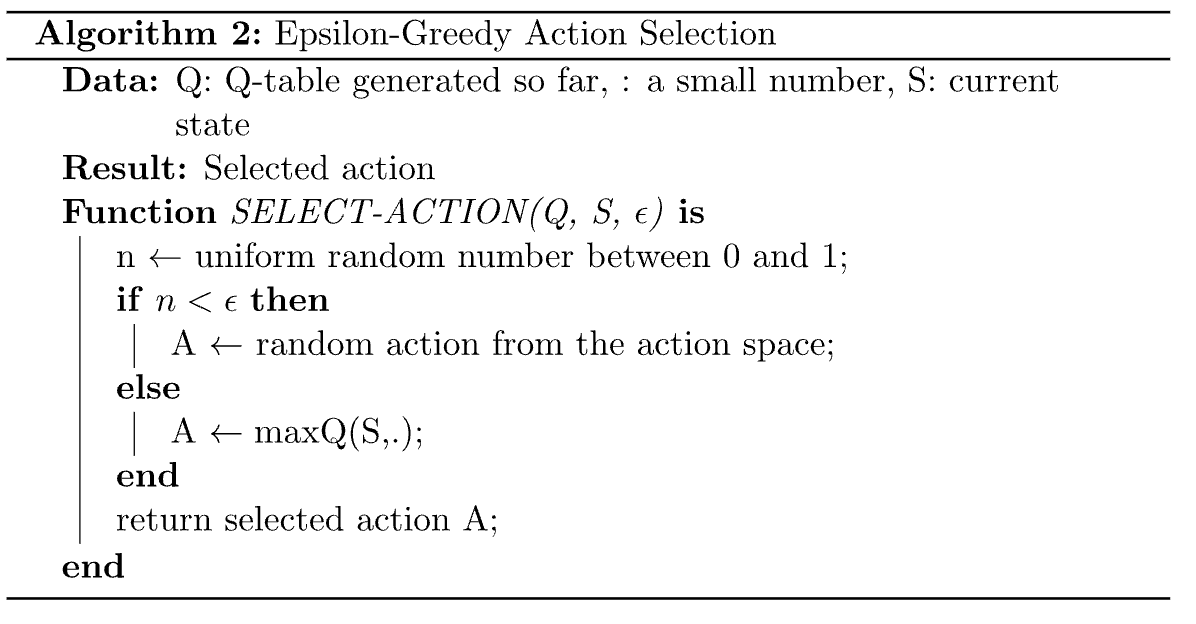

source:https://www.baeldung.com/cs/epsilon-greedy-q-learning

In [ ]:
num_players = 2 #Alice and Bob are our players

Q_Alice = [0]*len(actions_list) #the length of Q is the same length as Alice's list of Actions
Q_Bob = [0]*len(actions_list) #the length of Q is the same length as Bob's list of Actions

In [ ]:
def epsilon_Greedy_Policy_2x2(eps, playerName):

  p = np.random.random()

  if p < eps:
    index = np.random.choice(len(actions_list))
    action_chosen = actions_list[index]

  else:
    if(playerName == "Alice"):
      index = np.argmax(Q_Alice)
      action_chosen = actions_list[index]
    elif(playerName == "Bob"):
      index = np.argmax(Q_Bob)
      action_chosen = actions_list[index]

  return (action_chosen[0],action_chosen[1], index)

- constant learning rate for all players
- decaying epsilon
- adding discount factor gamma

NEXT TIME:
- percentage of getting 3,3
- search more about the gamma factor and the second bellman equation


In [ ]:
num_of_games = 100 #assuming that we want to play 1000 times
alice_reward = [0]*len(actions_list)
bob_reward = [0]*len(actions_list)

# Initialize parameters
gamma = 0.75 # Discount factor
alpha = 0.9 # Learning rate
epsilon = 0.02
#decay_rate = epsilon/num_of_games #0.5-(50*0.01) = 0

for t in range(num_of_games):

    theta1, phi1, action_index_Alice = epsilon_Greedy_Policy_2x2(epsilon,"Alice")
    theta2, phi2, action_index_Bob = epsilon_Greedy_Policy_2x2(epsilon, "Bob")

    qc = build_qcir_two_by_two_parameters(theta1, phi1, theta2, phi2)
    results = execute(qc, simulator, shots=1024).result().get_counts()
    payoff_alice, payoff_bob = get_payoff(results)

    alice_reward[action_index_Alice] = payoff_alice
    bob_reward[action_index_Bob] = payoff_bob

    Q_Alice[action_index_Alice] = Q_Alice[action_index_Alice] + alpha * (alice_reward[action_index_Alice]-(Q_Alice[action_index_Alice]))
    Q_Bob[action_index_Bob] = Q_Bob[action_index_Bob] + alpha * (bob_reward[action_index_Bob]-(Q_Bob[action_index_Bob]))


In [ ]:
for i in range(len(Q_Alice)):
  if(Q_Alice[i] > 2 and Q_Bob[i]>2):
    print(Q_Alice[i])
    print(Q_Bob[i])
    print('\n')

3.0
3.0


2.25
2.25




- varying learning rates for each player
- constant epsilon

In [ ]:
num_of_games = 50 #assuming that we want to play 1000 times
alice_reward = [0]*len(actions_list)
bob_reward = [0]*len(actions_list)
#learning_rate = 0.7
e=0.1
x = np.arange(0, 1, 0.1)
learning_rate_Alice_list = []
learning_rate_Bob_list = []

for t in range(num_of_games):
  for learning_rate_Alice in x:
    for learning_rate_Bob in x:
      theta1, phi1, action_index_Alice = epsilon_Greedy_Policy_2x2(e,"Alice")
      theta2, phi2, action_index_Bob = epsilon_Greedy_Policy_2x2(e, "Bob")

      qc = build_qcir_two_by_two_parameters(theta1, phi1, theta2, phi2)
      results = execute(qc, simulator, shots=1024).result().get_counts()
      payoff_alice, payoff_bob = get_payoff(results)

      alice_reward[action_index_Alice] = payoff_alice
      bob_reward[action_index_Bob] = payoff_bob

      Q_Alice[action_index_Alice] = Q_Alice[action_index_Alice] + learning_rate_Alice * (alice_reward[action_index_Alice]-(Q_Alice[action_index_Alice]))
      Q_Bob[action_index_Bob] = Q_Bob[action_index_Bob] + learning_rate_Bob * (bob_reward[action_index_Bob]-(Q_Bob[action_index_Bob]))

      learning_rate_Alice_list.append(learning_rate_Alice)
      learning_rate_Bob_list.append(learning_rate_Bob)

In [ ]:
for i in range(len(Q_Alice)):
  if(Q_Alice[i] > 2 and Q_Bob[i]>2):
    print(Q_Alice[i])
    print(Q_Bob[i])
    #print(learning_rate_Alice[i])
    #print(learning_rate_Bob_list[i])
    print('\n')

2.6874999999997757
2.369000094876293




**QLearning 3x3**

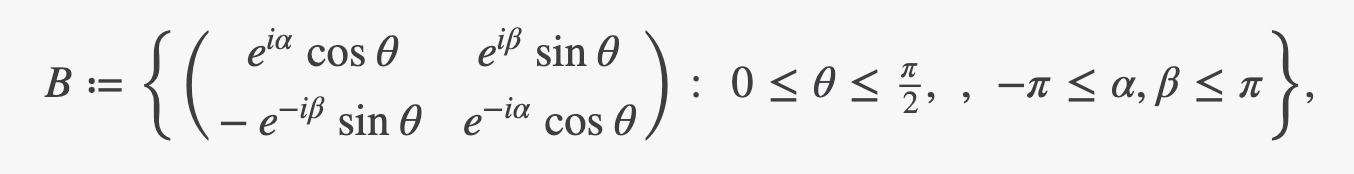

In [ ]:
def build_qcir_three_by_three_parameters(theta1, alpha1, beta1, theta2, alpha2, beta2):
  """
    Set up a quantum game. Both players have access to quantum strategies space
  """
  y = np.pi/2
  alice = np.array([
      [np.exp(1.0j*alpha1)*np.cos(theta1), np.exp(1.0j * beta1) * np.sin(theta1)],
      [-1*np.exp(-1.0j * beta1) * np.sin(theta1), np.exp(-1.0j*alpha1)*np.cos(theta1)]])

  bob = np.array([
      [np.exp(1.0j*alpha2)*np.cos(theta2), np.exp(1.0j * beta2) * np.sin(theta2)],
      [-1*np.exp(-1.0j * beta2) * np.sin(theta2), np.exp(-1.0j*alpha2)*np.cos(theta2)]])

  qc = QuantumCircuit(num_players)

  #identity matrix
  I = np.identity(2)

  #pauli matrix
  P = np.matrix([[0,1],[1,0]])

  #J is the quantum logic gate which entangles the two qubits of Alice & Bob
  J_real = (np.cos(y/2) * TensorProduct(I, I))
  J_imaginary = (np.sin(y/2)*TensorProduct(P,P))

  J = np.empty((4,4), dtype=np.complex128)
  J.real = J_real
  J.imag = J_imaginary

  J_unitary = UnitaryGate(Operator(J))
  qc.append(J_unitary, [0,1])
  qc.barrier()

  unitary_alice = UnitaryGate(Operator(alice))
  unitary_bob = UnitaryGate(Operator(bob))

  qc.append(unitary_alice, [0])
  qc.append(unitary_bob, [1])
  qc.barrier()

  Jdagger_unitary = UnitaryGate(Operator(J.conj().T))
  qc.append(Jdagger_unitary, [0,1])

  return qc


**Getting the Actions Ready**

In [ ]:
space_size = 4

actions_list = []

for theta in np.linspace(0, np.pi/2, space_size):
  for alpha in np.linspace(-np.pi, np.pi, space_size):
    for beta in np.linspace(-np.pi, np.pi, space_size):
        actions_list.append((theta,alpha,beta))

**Epsilon Greedy Function**

In [ ]:
num_players = 2 #Alice and Bob are our players

Q_Alice = [0]*len(actions_list) #the length of Q is the same length as Alice's list of Actions
Q_Bob = [0]*len(actions_list) #the length of Q is the same length as Bob's list of Actions

In [ ]:
"""
I used this source
https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/

a better way is to use 2D list. i=0 for Alice and i=1 for Bob. then use for loop that loops on i which is the number of players
"""

def epsilon_Greedy_Policy_3x3(epsilon, playerName):

  p = np.random.random()

  if p < epsilon:
    index = np.random.choice(len(actions_list))
    action_chosen = actions_list[index]

  else:
    if(playerName == "Alice"):
      index = np.argmax(Q_Alice)
      action_chosen = actions_list[index]
    elif(playerName == "Bob"):
      index = np.argmax(Q_Bob)
      action_chosen = actions_list[index]

  return (action_chosen[0],action_chosen[1],action_chosen[2], index)

**Play the game using the joint actions**

In [ ]:
num_of_games = 10000 #assuming that we want to play 1000 times
alice_reward = [0]*len(actions_list)
bob_reward = [0]*len(actions_list)

eps = 0.5
learning_rate_Alice_list = [0]
learning_rate_Bob_list = [0]

x = np.arange(0, 1, 0.1)

for t in range(num_of_games):
  for learning_rate_Alice in x:
    for learning_rate_Bob in x:
      theta1, alpha1, beta1, action_index_Alice = epsilon_Greedy_Policy_3x3(eps,"Alice")
      theta2, alpha2, beta2, action_index_Bob = epsilon_Greedy_Policy_3x3(eps,"Bob")

      qc = build_qcir_three_by_three_parameters(theta1, alpha1, beta1, theta2, alpha2, beta2)
      results = execute(qc, simulator, shots=1024).result().get_counts()
      payoff_alice, payoff_bob = get_payoff(results)

      alice_reward[action_index_Alice] = payoff_alice
      bob_reward[action_index_Bob] = payoff_bob

      Q_Alice[action_index_Alice] = Q_Alice[action_index_Alice] + learning_rate_Alice * (alice_reward[action_index_Alice]-(Q_Alice[action_index_Alice]))
      Q_Bob[action_index_Bob] = Q_Bob[action_index_Bob] + learning_rate_Bob * (bob_reward[action_index_Bob]-(Q_Bob[action_index_Bob]))

      learning_rate_Alice_list.append(learning_rate_Alice)
      learning_rate_Bob_list.append(learning_rate_Bob)

In [ ]:
for i in range(len(Q_Alice)):
  if(Q_Alice[i] > 2 and Q_Bob[i]>2):
    print("Alice Q")
    print(Q_Alice[i])
    print("Bob Q")
    print(Q_Bob[i])
    print("Alice alpha")
    print(learning_rate_Alice_list[i])
    print("Bob alpha")
    print(learning_rate_Bob_list[i])
    print('\n')

Alice Q
2.2369601463412243
Bob Q
2.0442723166677483
Alice alpha
0.30000000000000004
Bob alpha
0.1


